In [14]:
import pandas as pd

df = pd.read_csv("/content/Cyclomatic_Complexity.csv")

df["Month"] = pd.to_datetime(df["Month"], errors="coerce")
df["Avg. CC"] = pd.to_numeric(df["Avg. CC"], errors="coerce")
df["Avg. NLOC"] = pd.to_numeric(df["Avg. NLOC"], errors="coerce")

df = df.dropna(subset=["Month"])
df["Index"] = df.groupby("repo_name").cumcount() + 1

mean_values = df.groupby("repo_name", group_keys=False).apply(
    lambda group: pd.Series({
        "Mean_CC_Before_CI": group.loc[group["Index"] < 13, "Avg. CC"].mean(skipna=True),
        "Mean_NLOC_Before_CI": group.loc[group["Index"] < 13, "Avg. NLOC"].mean(skipna=True),
        "Mean_CC_After_CI": group.loc[group["Index"] >= 13, "Avg. CC"].mean(skipna=True),
        "Mean_NLOC_After_CI": group.loc[group["Index"] >= 13, "Avg. NLOC"].mean(skipna=True),
    })
).reset_index(drop=False)

mean_values.to_csv("ci_impact_analysis.csv", index=False)

<ipython-input-14-c64b71376fda>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_values = df.groupby("repo_name", group_keys=False).apply(


In [12]:
import pandas as pd

before_ci = df[df["Index"] < 13]  # Before CI (first 12 months)
after_ci = df[df["Index"] >= 13]  # After CI (CI start + 12 months after)

mean_cc_before = before_ci["Avg. CC"].mean(skipna=True)
mean_cc_after = after_ci["Avg. CC"].mean(skipna=True)
mean_nloc_before = before_ci["Avg. NLOC"].mean(skipna=True)
mean_nloc_after = after_ci["Avg. NLOC"].mean(skipna=True)

print(f"Overall Mean CC Before CI: {mean_cc_before:.4f}")
print(f"Overall Mean CC After CI: {mean_cc_after:.4f}")
print(f"Overall Mean NLOC Before CI: {mean_nloc_before:.4f}")
print(f"Overall Mean NLOC After CI: {mean_nloc_after:.4f}")

Overall Mean CC Before CI: 2.7272
Overall Mean CC After CI: 3.5784
Overall Mean NLOC Before CI: 13.5276
Overall Mean NLOC After CI: 14.1760


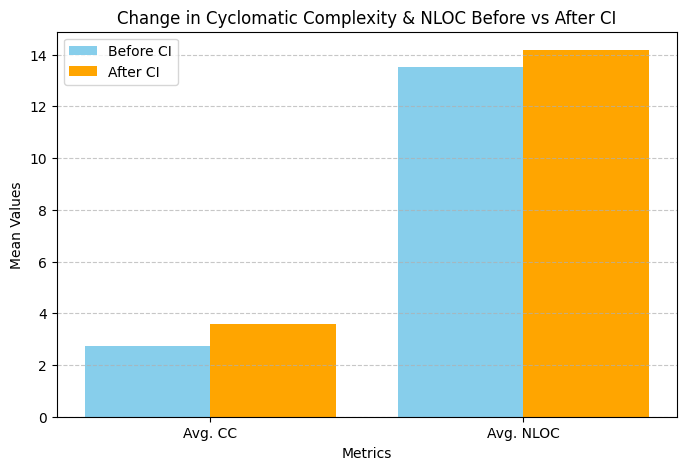

In [15]:
import matplotlib.pyplot as plt
import numpy as np

categories = ["Avg. CC", "Avg. NLOC"]
before_values = [mean_cc_before, mean_nloc_before]
after_values = [mean_cc_after, mean_nloc_after]

x = np.arange(len(categories))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, before_values, width=0.4, label="Before CI", color="skyblue")
plt.bar(x + 0.2, after_values, width=0.4, label="After CI", color="orange")
plt.xlabel("Metrics")
plt.ylabel("Mean Values")
plt.title("Change in Cyclomatic Complexity & NLOC Before vs After CI")
plt.xticks(x, categories)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [25]:
import pandas as pd
from scipy.stats import mannwhitneyu, wilcoxon
import numpy as np

df_filtered = df.dropna(subset=["Avg. CC"]).copy()
df_filtered["cc_change"] = df_filtered["Avg. CC"].shift(-12) - df_filtered["Avg. CC"]
df_filtered = df_filtered.dropna(subset=["cc_change"])

def cliffs_delta(before, after):
    n = len(before) * len(after)
    greater = sum(x > y for x in before for y in after)
    lesser = sum(x < y for x in before for y in after)
    return (greater - lesser) / n

cliffs_d_cc = cliffs_delta(df_filtered["Avg. CC"], df_filtered["cc_change"])

mannwhitney_u_stat, mannwhitney_u_p = mannwhitneyu(df_filtered["Avg. CC"], df_filtered["cc_change"])

wilcoxon_stat, wilcoxon_p = wilcoxon(df_filtered["Avg. CC"], df_filtered["cc_change"])

cc_results = {
    "Cliff's Delta (Avg. CC)": cliffs_d_cc,
    "Mann-Whitney U Test (Avg. CC) p-value": np.float64(mannwhitney_u_p),
    "Wilcoxon signed-rank Test p-value (Avg. CC) p-value": np.float64(wilcoxon_p)
}

for key, value in cc_results.items():
    print(f"{key}: {value}")

Cliff's Delta (Avg. CC): 0.8391458839989515
Mann-Whitney U Test (Avg. CC) p-value: 2.670619366883811e-176
Wilcoxon signed-rank Test p-value (Avg. CC) p-value: 2.3090192817776146e-89


In [26]:
alpha = 0.05
if mannwhitney_u_p < alpha:
    print("\nSignificant difference in Avg. CC before and after CI (Mann-Whitney U Test).")
else:
    print("\nNo significant difference in Avg. CC before and after CI (Mann-Whitney U Test).")

if wilcoxon_p < alpha:
    print("Significant difference in Avg. CC before and after CI (Wilcoxon Test).")
else:
    print("No significant difference in Avg. CC before and after CI (Wilcoxon Test).")


Significant difference in Avg. CC before and after CI (Mann-Whitney U Test).
Significant difference in Avg. CC before and after CI (Wilcoxon Test).


In [21]:
import pandas as pd
from scipy.stats import mannwhitneyu, wilcoxon
import numpy as np

df_filtered = df.dropna(subset=["Avg. NLOC"]).copy()
df_filtered["nloc_change"] = df_filtered["Avg. NLOC"].shift(-12) - df_filtered["Avg. NLOC"]
df_filtered = df_filtered.dropna(subset=["nloc_change"])

cohen_d_nloc = (df_filtered["Avg. NLOC"].mean() - df_filtered["nloc_change"].mean()) / df_filtered["Avg. NLOC"].std()

def cliffs_delta(before, after):
    n = len(before) * len(after)
    greater = sum(x > y for x in before for y in after)
    lesser = sum(x < y for x in before for y in after)
    return (greater - lesser) / n

cliffs_d_nloc = cliffs_delta(df_filtered["Avg. NLOC"], df_filtered["nloc_change"])

mannwhitney_u_stat, mannwhitney_u_p = mannwhitneyu(df_filtered["Avg. NLOC"], df_filtered["nloc_change"])

wilcoxon_stat, wilcoxon_p = wilcoxon(df_filtered["Avg. NLOC"], df_filtered["nloc_change"])

nloc_results = {
    "Cliff's Delta (Avg. NLOC)": cliffs_d_nloc,
    "Mann-Whitney U Test (Avg. NLOC) p-value": np.float64(mannwhitney_u_p),
    "Wilcoxon signed-rank Test p-value (Avg. NLOC) p-value": np.float64(wilcoxon_p)
    }

for key, value in nloc_results.items():
    print(f"{key}: {value}")

Cliff's Delta (Avg. NLOC): 0.8504863031413985
Mann-Whitney U Test (Avg. NLOC) p-value: 5.460732014414716e-181
Wilcoxon signed-rank Test p-value (Avg. NLOC) p-value: 1.3774845265177278e-104


In [24]:
if mannwhitney_u_p < alpha:
    print("Significant difference in Avg. NLOC before and after CI (Mann-Whitney U Test).")
else:
    print("No significant difference in Avg. NLOC before and after CI (Mann-Whitney U Test).")

if wilcoxon_p < alpha:
    print("Significant difference in Avg. NLOC before and after CI (Wilcoxon Test).")
else:
    print("No significant difference in Avg. NLOC before and after CI (Wilcoxon Test).")

Significant difference in Avg. NLOC before and after CI (Mann-Whitney U Test).
Significant difference in Avg. NLOC before and after CI (Wilcoxon Test).
